MEMO SDV :

In [12]:
import pandas as pd
import random, numpy as np, torch
from rdt import HyperTransformer
from rdt.transformers import UniformEncoder, FloatFormatter,LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
from sdv.metadata import SingleTableMetadata
import warnings
from sdmetrics.single_column import KSComplement, TVComplement
from sdmetrics.single_table import NewRowSynthesis
from sdmetrics.reports.single_table import QualityReport
from sdv.single_table import TVAESynthesizer, CTGANSynthesizer
from sklearn.decomposition import PCA
from sdmetrics.single_table import LogisticDetection, SVCDetection
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


url = "https://hbiostat.org/data/repo/rhc.csv"
df_rhc = pd.read_csv(url)
print(df_rhc.shape)
df_rhc.head()

(5735, 63)


,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [13]:
warnings.filterwarnings("ignore")
url = "https://hbiostat.org/data/repo/rhc.csv"
df = pd.read_csv(url)

df.drop(columns=[
    'ptid', 'Unnamed: 0', 'caseid', 'sadmdte', 'dschdte',
    'dthdte', 'lstctdte', 't3d30', 'cat2', 'adld3p'
], inplace=True, errors='ignore')
df = df[df.isnull().mean(axis=1) <= 0.8].reset_index(drop=True)

# Log-transform
for col in ['urin1', 'crea1', 'bili1', 'wblc1']:
    if col in df.columns:
        df[col] = np.log1p(df[col])

# Configuration HyperTransformer
ht = HyperTransformer()
cfg = {'sdtypes': {}, 'transformers': {}}

for col in df.columns:
    unique_vals = sorted(df[col].dropna().unique())

    if unique_vals == [0, 1]:
        cfg['sdtypes'][col] = 'categorical'
        cfg['transformers'][col] = LabelEncoder()
    elif pd.api.types.is_numeric_dtype(df[col]):
        cfg['sdtypes'][col] = 'numerical'
        cfg['transformers'][col] = FloatFormatter()
    else:
        cfg['sdtypes'][col] = 'categorical'
        cfg['transformers'][col] = LabelEncoder()

ht.set_config(cfg)
df_encoded = ht.fit_transform(df)

# metadata 
metadata = SingleTableMetadata()
for col, sdtype in cfg['sdtypes'].items():
    metadata.add_column(column_name=col, sdtype=sdtype)

# Décodage 
df_decoded = ht.reverse_transform(df_encoded)

# Vérification réversibilité
assert df.shape == df_decoded.shape, "Erreur : dimensions incohérentes après reverse_transform"

print("\nDimensions du jeu encodé :", df_encoded.shape)




Dimensions du jeu encodé : (5735, 54)


Entraînement du modèle TVAE

In [14]:

np.random.seed(42)
torch.manual_seed(42)

#  TVAE 
tvae = TVAESynthesizer(
    metadata=metadata,
    epochs=300,
    batch_size=256,
    embedding_dim=128,
    compress_dims=(64, 32),
    decompress_dims=(32, 64),
    loss_factor=1.0,
    l2scale=1e-5,
    verbose=True
)


tvae.fit(df_encoded)

synthetic_data_tvae = tvae.sample(num_rows=len(df_encoded))
synthetic_decoded_tvae = ht.reverse_transform(synthetic_data_tvae)

print(" Données synthétiques générées et décodées (TVAE) :")
print(synthetic_decoded_tvae.head())


Loss: 32.446: 100%|██████████| 300/300 [08:53<00:00,  1.78s/it]


 Données synthétiques générées et décodées (TVAE) :
            cat1   ca death  cardiohx  chfhx  dementhx  psychhx  chrpulhx  \
0            CHF   No   Yes         1      1         0        0         0   
1           COPD  Yes   Yes         0      0         0        0         1   
2  MOSF w/Sepsis  Yes   Yes         0      0         0        0         0   
3  MOSF w/Sepsis   No   Yes         0      0         0        0         0   
4           COPD   No   Yes         0      0         0        0         1   

   renalhx  liverhx  ...  gastr  renal  meta  hema  seps  trauma ortho  \
0        0        0  ...     No     No    No    No    No      No    No   
1        0        0  ...     No     No    No    No    No      No    No   
2        0        0  ...     No     No    No    No    No      No    No   
3        0        0  ...     No     No    No    No    No      No    No   
4        0        0  ...     No     No    No    No    No      No    No   

      urin1   race      income  
0  7.24

Evaluations

In [16]:
# Variables numériques et catégorielles selon la config
variables_numeriques_tvae = [col for col, typ in cfg['sdtypes'].items() if typ == 'numerical']
variables_categorielle_tvae = [col for col, typ in cfg['sdtypes'].items() if typ == 'categorical']

# KSComplement pour les variables numériques
ks_scores_tvae = {}
for col in variables_numeriques_tvae:
    if col in synthetic_decoded_tvae.columns and col in df.columns:
        real = df[col].dropna()
        synth = synthetic_decoded_tvae[col].dropna()
        if real.nunique() > 1 and synth.nunique() > 1:
            ks_scores_tvae[col] = KSComplement.compute(real_data=real, synthetic_data=synth)
ks_sorted_tvae = dict(sorted(ks_scores_tvae.items(), key=lambda x: x[1]))

# TVComplement pour les variables catégorielles
tv_scores_tvae = {}
for col in variables_categorielle_tvae:
    if col in synthetic_decoded_tvae.columns and col in df.columns:
        real = df[col].dropna()
        synth = synthetic_decoded_tvae[col].dropna()
        if real.nunique() > 1 and synth.nunique() > 1:
            tv_scores_tvae[col] = TVComplement.compute(real_data=real, synthetic_data=synth)
tv_sorted_tvae = dict(sorted(tv_scores_tvae.items(), key=lambda x: x[1], reverse=True))

# Rapport de qualité global avec SDV
metadata_dict = metadata.to_dict()
report_tvae = QualityReport()
report_tvae.generate(real_data=df, synthetic_data=synthetic_decoded_tvae, metadata=metadata_dict)
global_score_tvae = report_tvae.get_score()

# Distance au plus proche voisin (DCR)
dcr_score_tvae = NewRowSynthesis.compute(real_data=df, synthetic_data=synthetic_decoded_tvae, metadata=metadata_dict)

# Affichage
print(f"Score global (QualityReport) : {global_score_tvae:.4f}")
print(f"Score DCR : {dcr_score_tvae:.4f}")

print("\nKS scores :")
for k, v in ks_sorted_tvae.items():
    print(f"{k}: {v:.4f}")

print("\nTV scores :")
for k, v in tv_sorted_tvae.items():
    print(f"{k}: {v:.4f}")

print("\nColonnes potentiellement mal modélisées :")
for col, v in ks_sorted_tvae.items():
    if v > 0.5:
        print(f"KS trop élevé pour {col} : {v:.2f}")
for col, v in tv_sorted_tvae.items():
    if v < 0.5:
        print(f"TV trop faible pour {col} : {v:.2f}")


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 54/54 [00:00<00:00, 291.03it/s]|
Column Shapes Score: 85.36%

(2/2) Evaluating Column Pair Trends: |██████████| 1431/1431 [00:09<00:00, 158.65it/s]|
Column Pair Trends Score: 73.03%

Overall Score (Average): 79.19%

Score global (QualityReport) : 0.7919
Score DCR : 1.0000

KS scores :
urin1: 0.3584
resp1: 0.5198
edu: 0.5744
alb1: 0.6284
ph1: 0.6725
das2d3pc: 0.6982
meanbp1: 0.7384
scoma1: 0.7456
bili1: 0.7552
pot1: 0.7976
wblc1: 0.8038
temp1: 0.8054
paco21: 0.8115
pafi1: 0.8187
wtkilo1: 0.8493
crea1: 0.8554
hema1: 0.8997
age: 0.9140
sod1: 0.9316
aps1: 0.9426
hrt1: 0.9505
surv2md1: 0.9575

TV scores :
malighx: 0.9960
liverhx: 0.9862
gibledhx: 0.9861
swang1: 0.9799
renalhx: 0.9663
dth30: 0.9658
gastr: 0.9555
hema: 0.9548
neuro: 0.9533
cat1: 0.9529
renal: 0.9522
ca: 0.9494
chfhx: 0.9217
chrpulhx: 0.9179
resp: 0.9142
card: 0.9050
cardiohx: 0.8985
death: 0.8931
dnr1: 0.8898
seps: 0.8779
race: 0.7820
immunhx: 0.7681
sex: 0.7

Les résultats montrent que TVAE a globalement bien reproduit la structure des données réelles, avec un score de qualité globale de 79,2 %. Ce score résulte d’un bon apprentissage des distributions individuelles (85,4 %), mais d’une modélisation plus limitée des relations entre variables (73,0 %).

Le score DCR de 1,0 confirme que les données synthétiques sont diversifiées et non copiées, ce qui témoigne d’un bon respect du caractère synthétique attendu.

Pour les variables catégorielles, les résultats sont très satisfaisants : la majorité des scores TV dépassent 0,95, ce qui traduit une bonne reproduction des répartitions observées.

En revanche, plusieurs variables numériques (ex. crea1, wblc1, temp1, scoma1, age) affichent des scores KS > 0,8, révélant des écarts notables par rapport aux distributions réelles. Ces limites peuvent s’expliquer par une asymétrie marquée ou une dispersion importante difficile à capturer.

Malgré ces défauts localisés, les données générées restent cohérentes et utilisables dans la majorité des cas.

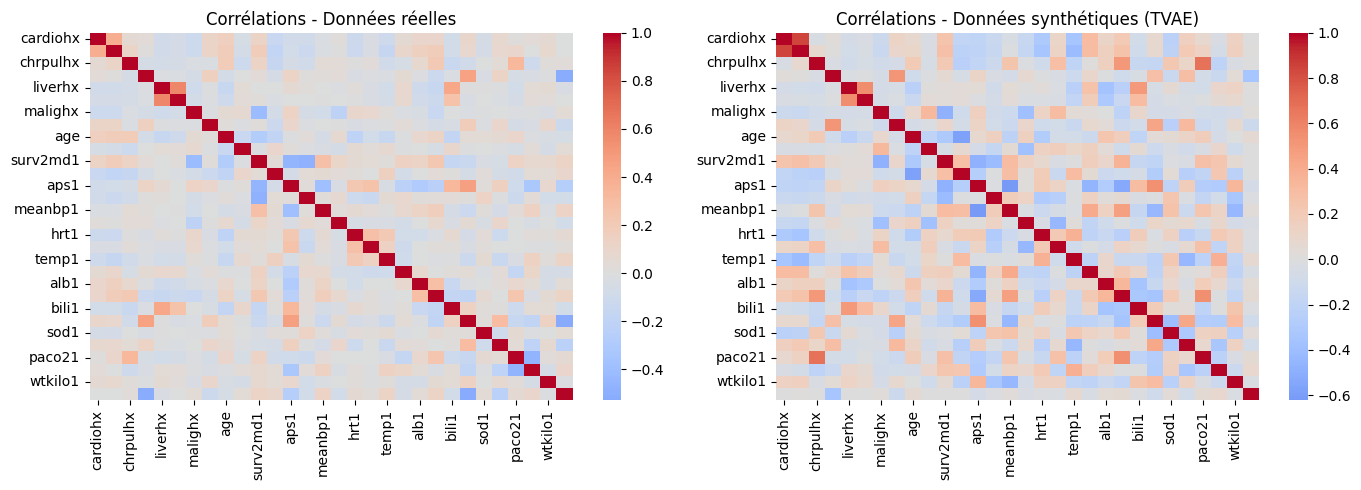

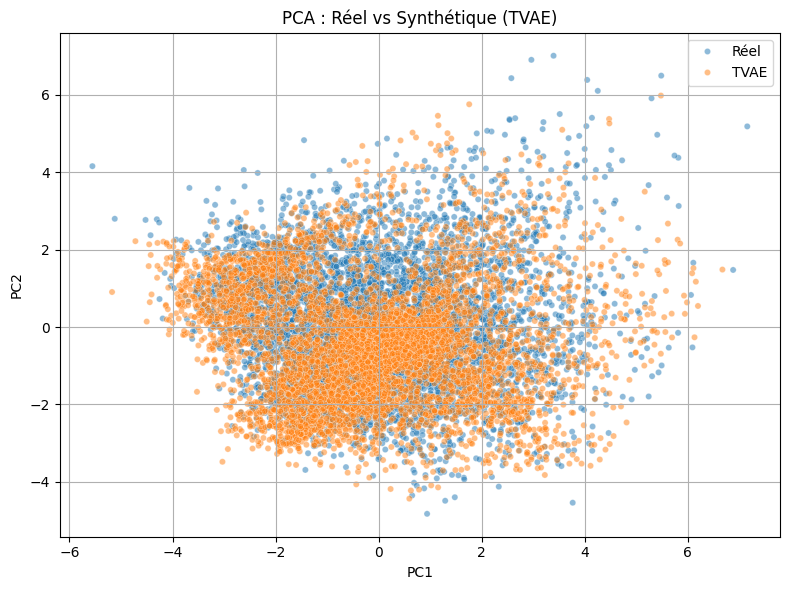

In [17]:

# Colonnes constantes dans les données synthétiques
colonnes_non_constantes = [
    col for col in synthetic_decoded_tvae.columns
    if synthetic_decoded_tvae[col].nunique(dropna=True) > 1
]

# Colonnes numériques non constantes
colonnes_utiles = [
    col for col in colonnes_non_constantes
    if pd.api.types.is_numeric_dtype(df[col])
]

# Heatmaps comparatives
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(df[colonnes_utiles].corr(), cmap="coolwarm", center=0)
plt.title("Corrélations - Données réelles")

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_decoded_tvae[colonnes_utiles].corr(), cmap="coolwarm", center=0)
plt.title("Corrélations - Données synthétiques (TVAE)")

plt.tight_layout()
plt.show()

# PCA avec StandardScaler
df_encoded_filtré = df_encoded[colonnes_utiles]
synthetic_filtré = tvae.sample(num_rows=len(df_encoded))[colonnes_utiles]

scaler = StandardScaler()
real_scaled = scaler.fit_transform(df_encoded_filtré)
synth_scaled = scaler.transform(synthetic_filtré)

pca = PCA(n_components=2)
pca_real = pca.fit_transform(real_scaled)
pca_synth = pca.transform(synth_scaled)

df_pca = pd.DataFrame({
    'PC1': np.concatenate([pca_real[:, 0], pca_synth[:, 0]]),
    'PC2': np.concatenate([pca_real[:, 1], pca_synth[:, 1]]),
    'type': ['Réel'] * len(pca_real) + ['TVAE'] * len(pca_synth)
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='type', alpha=0.5, s=20)
plt.title("PCA : Réel vs Synthétique (TVAE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Les heatmaps montrent que TVAE capture correctement les structures de corrélation principales, notamment autour d’aps1, surv2md1 et age. Cependant, les corrélations secondaires sont souvent atténuées, ce qui limite la restitution des interactions plus fines entre variables.

La PCA révèle un chevauchement global satisfaisant entre les données réelles et synthétiques. Toutefois, les points TVAE sont légèrement plus concentrés autour du centre, traduisant une variabilité plus faible. Cela peut refléter une sous-modélisation locale ou un encodage trop restrictif.

En résumé, TVAE reproduit bien les tendances générales, mais reste limité sur la finesse des interactions et la diversité locale des données générées.

In [18]:
#  NNDR 
nndr_score_tvae = NewRowSynthesis.compute(
    real_data=df,
    synthetic_data=synthetic_decoded_tvae,
    metadata=metadata.to_dict()
)
print(f" NNDR score TVAE : {nndr_score_tvae:.4f}")

# Détection via LogisticRegression
detection_logreg_tvae = LogisticDetection.compute(
    real_data=df,
    synthetic_data=synthetic_decoded_tvae,
    metadata=metadata.to_dict()
)
print(f" Détection TVAE (Logistic) : {detection_logreg_tvae:.4f}")

# Détection via SVC
detection_svc_tvae = SVCDetection.compute(
    real_data=df,
    synthetic_data=synthetic_decoded_tvae,
    metadata=metadata.to_dict()
)
print(f"Détection TVAE (SVC) : {detection_svc_tvae:.4f}")


 NNDR score TVAE : 1.0000
 Détection TVAE (Logistic) : 0.0567
Détection TVAE (SVC) : 0.2111


Le score NNDR = 1.0000 confirme qu’aucune ligne synthétique n’est trop proche d’une ligne réelle, ce qui garantit l’absence de fuite d’identité. Les scores de détection sont faibles (0.0567 en régression logistique, 0.2111 en SVC), bien en dessous du seuil de hasard (0.5), ce qui signifie que les données synthétiques sont difficilement distinguables des vraies.
Le modèle respecte la confidentialité, tout en maintenant une bonne diversité. Un résultat très satisfaisant.

Entraînement du modèle CTGAN 

In [19]:

np.random.seed(42)
torch.manual_seed(42)

#  CTGAN 
ctgan = CTGANSynthesizer(
    metadata=metadata,
    epochs=300,              
    batch_size=250,           
    embedding_dim=64,        
    generator_lr=2e-4,
    discriminator_lr=2e-4,
    verbose=True
)


ctgan.fit(df_encoded)


synthetic_data_ctgan = ctgan.sample(num_rows=len(df_encoded))
synthetic_decoded_ctgan = ht.reverse_transform(synthetic_data_ctgan)

print(" Données synthétiques générées et décodées (CTGAN) :")
print(synthetic_decoded_ctgan.head())


Gen. (-6.95) | Discrim. (-0.21): 100%|██████████| 300/300 [23:57<00:00,  4.79s/it]


 Données synthétiques générées et décodées (CTGAN) :
            cat1          ca death  cardiohx  chfhx  dementhx  psychhx  \
0           COPD  Metastatic   Yes         1      0         0        0   
1  MOSF w/Sepsis          No   Yes         0      0         0        0   
2  MOSF w/Sepsis          No   Yes         1      1         1        0   
3  MOSF w/Sepsis          No   Yes         1      0         0        0   
4  MOSF w/Sepsis          No   Yes         0      0         0        0   

   chrpulhx  renalhx  liverhx  ...  gastr  renal  meta  hema  seps  trauma  \
0         0        0        0  ...     No     No    No    No    No      No   
1         0        0        0  ...     No     No    No    No    No      No   
2         0        0        0  ...     No     No    No    No    No      No   
3         1        0        0  ...     No     No    No    No   Yes      No   
4         1        0        1  ...     No     No    No    No    No      No   

  ortho     urin1   race      inc

Evaluations 

In [20]:

variables_numeriques_ctgan = [col for col, typ in cfg['sdtypes'].items() if typ == 'numerical']
variables_categorielle_ctgan = [col for col, typ in cfg['sdtypes'].items() if typ == 'categorical']

# KSComplement
ks_scores_ctgan = {}
for col in variables_numeriques_ctgan:
    if col in synthetic_decoded_ctgan.columns and col in df.columns:
        real = df[col].dropna()
        synth = synthetic_decoded_ctgan[col].dropna()
        if real.nunique() > 1 and synth.nunique() > 1:
            ks_scores_ctgan[col] = KSComplement.compute(real_data=real, synthetic_data=synth)
ks_sorted_ctgan = dict(sorted(ks_scores_ctgan.items(), key=lambda x: x[1]))

# TVComplement
tv_scores_ctgan = {}
for col in variables_categorielle_ctgan:
    if col in synthetic_decoded_ctgan.columns and col in df.columns:
        real = df[col].dropna()
        synth = synthetic_decoded_ctgan[col].dropna()
        if real.nunique() > 1 and synth.nunique() > 1:
            tv_scores_ctgan[col] = TVComplement.compute(real_data=real, synthetic_data=synth)
tv_sorted_ctgan = dict(sorted(tv_scores_ctgan.items(), key=lambda x: x[1], reverse=True))

# Rapport de qualité global avec SDV
metadata_dict = metadata.to_dict()
report_ctgan = QualityReport()
report_ctgan.generate(real_data=df, synthetic_data=synthetic_decoded_ctgan, metadata=metadata_dict)
global_score_ctgan = report_ctgan.get_score()

# Distance au plus proche voisin (DCR)
dcr_score_ctgan = NewRowSynthesis.compute(real_data=df, synthetic_data=synthetic_decoded_ctgan, metadata=metadata_dict)

# Affichage
print(f"Score global (QualityReport) : {global_score_ctgan:.4f}")
print(f"Score DCR : {dcr_score_ctgan:.4f}")

print("\nKS scores :")
for k, v in ks_sorted_ctgan.items():
    print(f"{k}: {v:.4f}")

print("\nTV scores :")
for k, v in tv_sorted_ctgan.items():
    print(f"{k}: {v:.4f}")

print("\nColonnes potentiellement mal modélisées :")
for col, v in ks_sorted_ctgan.items():
    if v > 0.5:
        print(f"KS trop élevé pour {col} : {v:.2f}")
for col, v in tv_sorted_ctgan.items():
    if v < 0.5:
        print(f"TV trop faible pour {col} : {v:.2f}")


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 54/54 [00:00<00:00, 229.46it/s]|
Column Shapes Score: 86.38%

(2/2) Evaluating Column Pair Trends: |██████████| 1431/1431 [00:21<00:00, 66.28it/s]|
Column Pair Trends Score: 80.57%

Overall Score (Average): 83.48%

Score global (QualityReport) : 0.8348
Score DCR : 1.0000

KS scores :
hema1: 0.5501
alb1: 0.5719
urin1: 0.5770
aps1: 0.6317
bili1: 0.6818
hrt1: 0.7269
edu: 0.7294
temp1: 0.7432
paco21: 0.7733
wtkilo1: 0.7787
das2d3pc: 0.7953
meanbp1: 0.8073
scoma1: 0.8146
age: 0.8230
ph1: 0.8485
resp1: 0.8833
pot1: 0.8914
crea1: 0.8975
pafi1: 0.9048
sod1: 0.9118
surv2md1: 0.9269
wblc1: 0.9358

TV scores :
cardiohx: 0.9990
meta: 0.9970
ortho: 0.9929
hema: 0.9909
trauma: 0.9892
neuro: 0.9864
amihx: 0.9812
gibledhx: 0.9798
renalhx: 0.9754
psychhx: 0.9749
dementhx: 0.9705
transhx: 0.9702
liverhx: 0.9684
gastr: 0.9569
dnr1: 0.9527
sex: 0.9505
renal: 0.9489
seps: 0.9468
resp: 0.9458
ca: 0.9357
chrpulhx: 0.9170
race: 0.8919
chfhx: 

Les résultats montrent que le modèle CTGAN a globalement bien reproduit la structure des données réelles, avec un score de qualité globale de 83,5 %. Ce score est la moyenne de deux composantes : 86,4 % pour la forme des distributions des colonnes, et 80,6 % pour les tendances entre les paires de colonnes. Les distributions individuelles sont donc bien apprises, mais les relations entre variables restent partiellement modélisées.

Le score DCR est de 1,0, indiquant une diversité élevée sans duplication des données réelles. C’est un très bon indicateur de confidentialité.

Les variables catégorielles sont bien modélisées, avec des scores TV majoritairement supérieurs à 0,95, ce qui reflète une bonne restitution des répartitions observées.

En revanche, les variables numériques posent davantage de problèmes. Plus de 20 colonnes, dont crea1, resp1, ph1, ou encore aps1, présentent des scores KS supérieurs à 0,8. Ces écarts signalent une mauvaise reproduction des distributions réelles, probablement liée à la complexité ou à la dispersion de certaines variables. Malgré ces limites, les données générées restent cohérentes et exploitables.

In [21]:
# NNDR
nndr_score_ctgan = NewRowSynthesis.compute(
    real_data=df,
    synthetic_data=synthetic_decoded_ctgan,
    metadata=metadata.to_dict()
)
print(f"NNDR score CTGAN : {nndr_score_ctgan:.4f}")

# Détection via LogisticRegression
detection_logreg_ctgan = LogisticDetection.compute(
    real_data=df,
    synthetic_data=synthetic_decoded_ctgan,
    metadata=metadata.to_dict()
)
print(f"Détection CTGAN (Logistic)  : {detection_logreg_ctgan:.4f}")

# Détection via SVC
detection_svc_ctgan = SVCDetection.compute(
    real_data=df,
    synthetic_data=synthetic_decoded_ctgan,
    metadata=metadata.to_dict()
)
print(f"Détection CTGAN (SVC)  : {detection_svc_ctgan:.4f}")


NNDR score CTGAN : 1.0000
Détection CTGAN (Logistic)  : 0.0819
Détection CTGAN (SVC)  : 0.0842


CTGAN obtient un score NNDR de 1,00, ce qui indique une excellente diversité (les données synthétiques sont très différentes des vraies). Les scores de détection sont faibles : 0,08 avec la régression logistique et 0,08 avec SVC. Cela signifie que les données synthétiques sont difficilement distinguables des données réelles, ce qui témoigne d’un bon niveau de réalisme et de confidentialité.

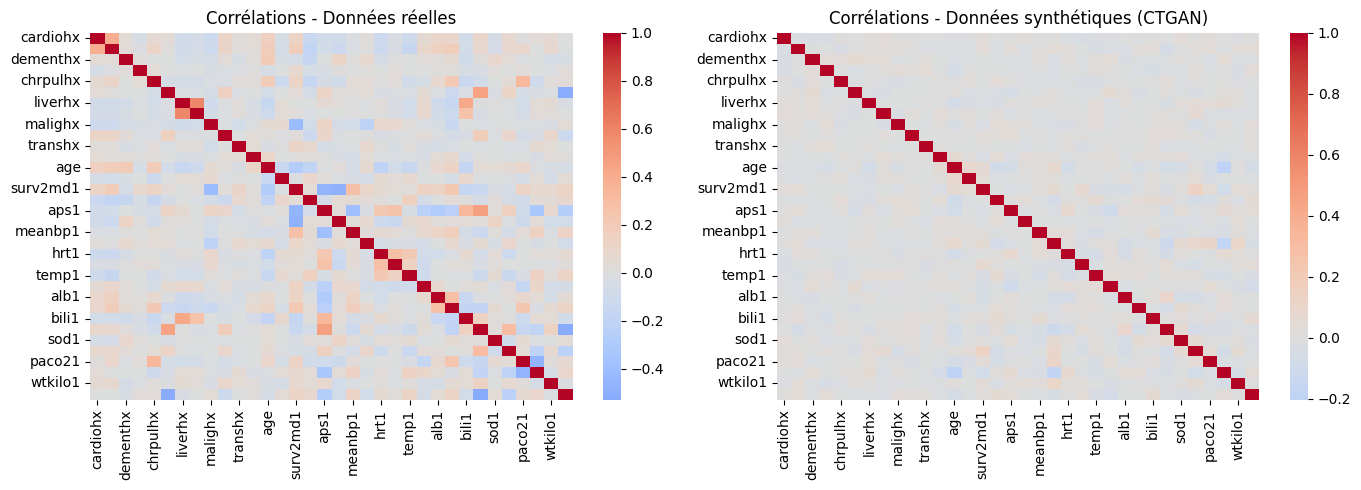

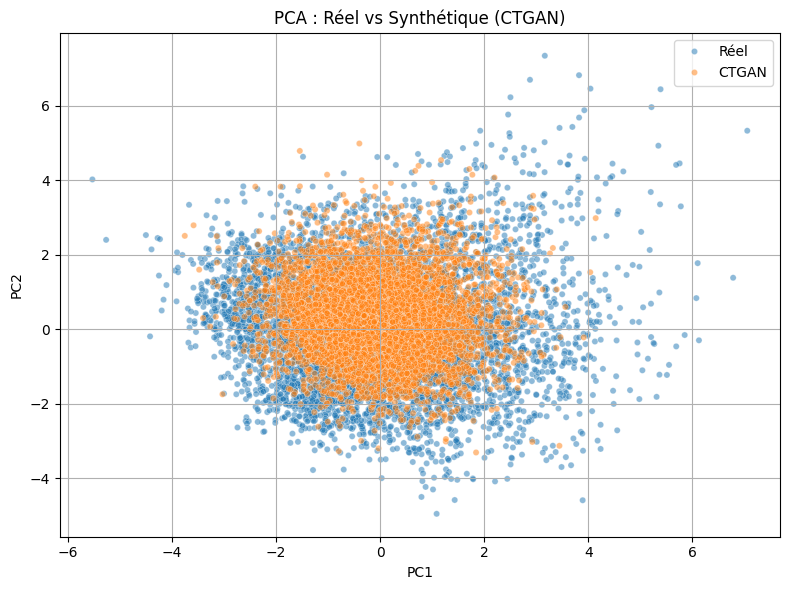

In [22]:
# Colonnes non constantes dans les données synthétiques CTGAN
colonnes_non_constantes_ctgan = [
    col for col in synthetic_decoded_ctgan.columns
    if synthetic_decoded_ctgan[col].nunique(dropna=True) > 1
]

# Colonnes numériques non constantes
colonnes_utiles_ctgan = [
    col for col in colonnes_non_constantes_ctgan
    if pd.api.types.is_numeric_dtype(df[col])
]

# Heatmaps comparatives
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(df[colonnes_utiles_ctgan].corr(), cmap="coolwarm", center=0)
plt.title("Corrélations - Données réelles")

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_decoded_ctgan[colonnes_utiles_ctgan].corr(), cmap="coolwarm", center=0)
plt.title("Corrélations - Données synthétiques (CTGAN)")

plt.tight_layout()
plt.show()

# PCA 
df_encoded_filtré_ctgan = df_encoded[colonnes_utiles_ctgan]
synthetic_filtré_ctgan = synthetic_data_ctgan[colonnes_utiles_ctgan]

scaler = StandardScaler()
real_scaled = scaler.fit_transform(df_encoded_filtré_ctgan)
synth_scaled = scaler.transform(synthetic_filtré_ctgan)

pca = PCA(n_components=2)
pca_real = pca.fit_transform(real_scaled)
pca_synth = pca.transform(synth_scaled)

df_pca_ctgan = pd.DataFrame({
    'PC1': np.concatenate([pca_real[:, 0], pca_synth[:, 0]]),
    'PC2': np.concatenate([pca_real[:, 1], pca_synth[:, 1]]),
    'type': ['Réel'] * len(pca_real) + ['CTGAN'] * len(pca_synth)
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_ctgan, x='PC1', y='PC2', hue='type', alpha=0.5, s=20)
plt.title("PCA : Réel vs Synthétique (CTGAN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Les corrélations entre variables sont nettement atténuées dans les données synthétiques générées par CTGAN, ce qui traduit une modélisation insuffisante des dépendances structurelles. La projection en PCA montre une bonne superposition des nuages réels et synthétiques, mais les points synthétiques présentent une variabilité plus faible, suggérant un certain manque de diversité dans l’espace latent.

comparaison TVAE ET CTGAN 

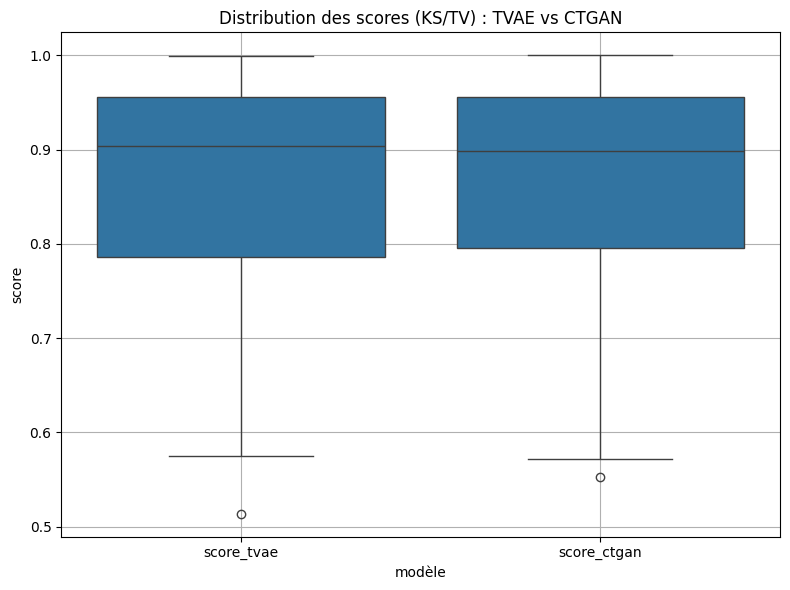

 Moyenne score TVAE : 0.861
 Moyenne score CTGAN : 0.865
Médiane score TVAE : 0.904
 Médiane score CTGAN : 0.898
 Pourcentage de variables où TVAE > CTGAN : 46.3%


In [24]:

synth_tvae = tvae.sample(num_rows=df_encoded.shape[0])
synth_ctgan = ctgan.sample(num_rows=df_encoded.shape[0])


types = cfg['sdtypes']
results = []

for col, typ in types.items():
    if col in df_encoded.columns and col in synth_tvae.columns and col in synth_ctgan.columns:
        try:
            real = df_encoded[col].dropna()
            syn_tvae = synth_tvae[col].dropna()
            syn_ctgan = synth_ctgan[col].dropna()

            if real.nunique() < 2:
                continue  

            if typ == 'numerical':
                score_tvae = KSComplement.compute(real_data=real, synthetic_data=syn_tvae)
                score_ctgan = KSComplement.compute(real_data=real, synthetic_data=syn_ctgan)
            elif typ == 'categorical':
                score_tvae = TVComplement.compute(real_data=real, synthetic_data=syn_tvae)
                score_ctgan = TVComplement.compute(real_data=real, synthetic_data=syn_ctgan)
            else:
                continue  

            results.append({
                'variable': col,
                'type': typ,
                'score_tvae': score_tvae,
                'score_ctgan': score_ctgan
            })

        except Exception as e:
            print(f" Erreur sur {col} : {e}")


df_scores = pd.DataFrame(results)

#  Boxplot 
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_scores.melt(id_vars=['variable', 'type'], 
                                value_vars=['score_tvae', 'score_ctgan'],
                                var_name='modèle', value_name='score'),
            x='modèle', y='score')
plt.title("Distribution des scores (KS/TV) : TVAE vs CTGAN")
plt.grid(True)
plt.tight_layout()
plt.show()


mean_tvae = df_scores['score_tvae'].mean()
mean_ctgan = df_scores['score_ctgan'].mean()
median_tvae = df_scores['score_tvae'].median()
median_ctgan = df_scores['score_ctgan'].median()
pct_tvae_better = (df_scores['score_tvae'] > df_scores['score_ctgan']).mean() * 100

print(f" Moyenne score TVAE : {mean_tvae:.3f}")
print(f" Moyenne score CTGAN : {mean_ctgan:.3f}")
print(f"Médiane score TVAE : {median_tvae:.3f}")
print(f" Médiane score CTGAN : {median_ctgan:.3f}")
print(f" Pourcentage de variables où TVAE > CTGAN : {pct_tvae_better:.1f}%")


Les scores de similarité univariée confirment que TVAE et CTGAN reproduisent correctement les distributions des variables réelles. Les performances globales sont proches : moyenne de 0.861 pour TVAE contre 0.865 pour CTGAN, médianes respectives de 0.904 et 0.898. Aucun modèle ne domine clairement, TVAE étant légèrement meilleur sur 46,3 % des variables. Les quelques outliers indiquent que certaines variables restent mal modélisées dans les deux cas.